In [1]:
import os, sys, glob
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sys.path.append('src')
import models.yamnet_tf2.yamnet_modified as yamnet
import models.yamnet_tf2.params as yamnet_params
params = yamnet_params.Params(sample_rate=16000, patch_hop_seconds=0.25)

# from dataload_utils.data_load import get_dataset, get_filenames_and_classnames_list
import dataload_utils.data_load as data_load
from dataload_utils.data_aug import mix_up

SEED = 42
random.seed(SEED)
tf.random.set_seed(SEED)

parent_dir = "C:\\Users\\User\\Documents\\cer_dataset_16k_flattened_resampled\\"
dataset_loader = data_load.Dataset_loader(parent_dir, params)
filenames_all = dataset_loader.__filenames_all__
classes = dataset_loader.__classes__
num_classes = dataset_loader.__num_classes__
print("classes: {}, num_classes: {}".format(classes, num_classes))

Number of files in Class_00_Modified_car_engines: 4644
Number of files in Class_01_Regular_Vehicles: 3873
Number of files in Class_02_Tires_and_Skidding: 1144
Number of files in Class_03_Tools_and_Mechanisms: 6049
Number of files in Class_04_Explosion: 1295
Number of files in Class_05_Environmental_Sounds: 6723
Number of files:  23728
classes: ['Class_00_Modified_car_engines', 'Class_01_Regular_Vehicles', 'Class_02_Tires_and_Skidding', 'Class_03_Tools_and_Mechanisms', 'Class_04_Explosion', 'Class_05_Environmental_Sounds'], num_classes: 6


In [4]:
# To do real shuffling
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = len(classes)
batch_size=64
random.shuffle(filenames_all)
filenames_train = filenames_all[:int(len(filenames_all)*0.7)]
filenames_eval = filenames_all[int(len(filenames_all)*0.7):int(len(filenames_all)*0.9)]
filenames_test = filenames_all[int(len(filenames_all)*0.9):]

# Training set preparation
dataset_aug = dataset_loader.get_dataset(filenames_train, augment=True)
train_dataset = dataset_aug.shuffle(batch_size*2).batch(batch_size) # Batch before doing mixup

# Mixup -
random.shuffle(filenames_train)
dataset_no_aug = dataset_loader.get_dataset(filenames_train, augment=False)

zipped_ds = tf.data.Dataset.zip((
    dataset_aug.shuffle(batch_size*2).batch(batch_size), 
    dataset_no_aug.shuffle(batch_size*2).batch(batch_size)
    ))

train_dataset = zipped_ds.map(
    map_func = lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), 
    num_parallel_calls=AUTOTUNE
    )

eval_dataset = dataset_loader.get_dataset(filenames_eval, augment=False).shuffle(batch_size*2).batch(batch_size)
test_dataset = dataset_loader.get_dataset(filenames_test, augment=False, flat_map=False).shuffle(batch_size*2)#.batch(batch_size)

train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
eval_dataset = eval_dataset.cache().prefetch(AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(AUTOTUNE)

# length = len(list(dataset_train_eval))
# print("Total length of dataset: ", length)

In [9]:
import datetime
MODEL_NAME='YAMNET'

# Paths
training_path = "./training/{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

model_training_path = training_path + "/{}".format(MODEL_NAME)
ckp_path = model_training_path + "/checkpoints/cp.ckpt"
log_path = model_training_path + "/logs/fit"    
hd5_path = model_training_path + "/model.hd5"
cfm_path = model_training_path + "/confusion_matrix.png"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,
                                                save_weights_only=True,
                                                verbose=1)
# Create a tensorboard callback                         
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)

# Declare model
Yamnet = yamnet.Yamnet_modified(NUM_CLASSES)
yamnet_model = Yamnet.model()

yamnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), #from_logits=True
    metrics=['accuracy'],
)

# Fit model
yamnet_model.fit(train_dataset, validation_data = eval_dataset, epochs=40, 
    verbose=1, callbacks=[cp_callback,tensorboard_callback])

# Evaluate performance of model with test fold (that it wasn't trained on)
yamnet_model.load_weights(ckp_path)
loss, acc = yamnet_model.evaluate(test_dataset, verbose=2)


Epoch 1/40
      2/Unknown - 10s 1s/step - loss: 4.7736 - accuracy: 0.2891

KeyboardInterrupt: 

In [ ]:
# training_path = "D:\\Github\\YAMNET\\yamnet_short\\training\\20220409-182437" #Yamnet original
training_path = "D:\\Github\\YAMNET\\yamnet_short\\training\\20220409-195324"# Dropout
ckp_path = training_path + "/fold{}/checkpoints/cp.ckpt".format(i+1)

yamnet_model.load_weights(ckp_path)
loss, acc = yamnet_model.evaluate(test_dataset, verbose=2)
# print(acc)

533/533 - 8s - loss: 0.7207 - accuracy: 0.8561 - 8s/epoch - 15ms/step


Testing accuracy:  0.8561317984259368


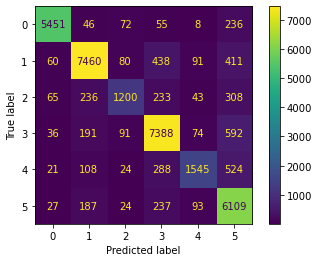

In [ ]:
# test_samples = test_dataset.map(lambda x,y: x)
# test_labels = test_dataset.map(lambda x,y: y)

# Get y_preds = predictions made by model
y_preds,y_trues = [],[]
for x_test, y_true in list(test_dataset):
    y_pred = np.argmax(yamnet_model.predict(x_test), axis=1)
    y_true = np.argmax(y_true, axis=1)
    y_preds.extend(y_pred)
    y_trues.extend(y_true)
y_trues = np.array(y_trues)

y_preds = np.array(y_preds)

accuracy = accuracy_score(y_trues, y_preds)
print("Testing accuracy: ", accuracy)
cm = ConfusionMatrixDisplay.from_predictions(y_trues, y_preds)
cm.figure_.savefig(cfm_path,dpi=500)